In [1]:
!pip install seaborn
!pip install matplotlib
!pip install plotly
!pip install gensim
!python -m spacy download en_core_web_sm
## Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from bs4 import BeautifulSoup

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors
from gensim.utils import simple_preprocess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 156.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Reading in Combined Reviews CSV File

combined_reviews = pd.read_csv("Data/Part2/sentiment_reviews.csv")
combined_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(combined_reviews.shape)
combined_reviews.head(3)

(500277, 23)


,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,month_year,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,1,00:01:03,2015-01,48,243,4.900000,12,"wow! yummy, different, delicious. favorite lam...",0.380051,0.733838,0.000,0.660,0.340,0.9588
1,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2013,6,11:21:25,2013-06,42,276,5.595238,17,tremendous service (big shout douglas) complem...,0.218750,0.579167,0.027,0.763,0.210,0.8360
2,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,2014,11,15:30:27,2014-11,81,419,4.185185,32,absolute favorite cafe city. black white latte...,0.391171,0.609921,0.025,0.738,0.237,0.9679


In [3]:
# Filtering for reviews that have 0.0 scores across 3 metrics: polarity, subjectivity, compound

dropped_reviews = combined_reviews[(combined_reviews.polarity ==0.0) & (combined_reviews.compound==0.0) & (combined_reviews.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(809, 23)


,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,month_year,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
384543,8ihXabW5-eZoA6QgcXI3ag,4R2KR_-FybS7oegGrXjHVg,5.0,0,0,0,這是我出差吃肉的第二天，這家餐廳的地點之前是銀行，到地下室還能看見以前銀行金庫的大門，不要錯...,2019-06-03 23:08:44,2019,6,23:08:44,2019-06,4,168,26.833333,0,這是我出差吃肉的第二天，這家餐廳的地點之前是銀行，到地下室還能看見以前銀行金庫的大門，不要錯...,0.0,0.0,0.0,1.0,0.0,0.0
18391,mjkwvjbbTeJBjPYmy7ZgMg,j99PtxlKTW_u5alE4jiqHQ,2.0,5,4,5,Judge the authenticity of an Italian restauran...,2008-03-29 00:45:40,2008,3,00:45:40,2008-03,28,165,4.928571,16,judge authenticity italian restaurant checkere...,0.0,0.0,0.0,1.0,0.0,0.0
434790,8ihXabW5-eZoA6QgcXI3ag,iksVwRfpWymIUUFqw0tXpw,4.0,0,0,0,這是我出差吃肉的第三天，前兩天吃完牛排還說不想再看到牛肉了，但今天的和牛肉片又讓我驚豔到了。...,2019-06-03 23:15:18,2019,6,23:15:18,2019-06,1,141,34.500000,0,這是我出差吃肉的第三天，前兩天吃完牛排還說不想再看到牛肉了，但今天的和牛肉片又讓我驚豔到了。...,0.0,0.0,0.0,1.0,0.0,0.0
7647,Oem5e-7g5QIifQw2YEtpjA,U30ggGzFpXvc2NZYwOW3qg,5.0,2,1,0,I haven't even finished moving into the neighb...,2013-06-02 15:26:13,2013,6,15:26:13,2013-06,23,121,4.304348,12,even finished moving neighborhood already goal...,0.0,0.0,0.0,1.0,0.0,0.0
397759,u4v3UJ6GBbeUpjCDTPrjsA,D7CBOXSfm0RetkuMbJ0KkA,1.0,1,0,0,Check the dates on produce and most items boug...,2020-10-05 19:31:53,2020,10,19:31:53,2020-10,22,117,4.363636,10,check date produce item bought edamame 27 day ...,0.0,0.0,0.0,1.0,0.0,0.0


As seen from the table above, it seems like these reviews are written in non-english languages or are gibberish. Thus, sentimet analysis libraries are not able to compute relevant scores for these reviews. Hence, for the purpose of this project, we will be removing these 630 rows of reviews.

In [4]:
# Dropping these filtered rows
combined_reviews = combined_reviews.drop(index = dropped_reviews.index)
print(combined_reviews.shape)
combined_reviews.sample(3)

(499468, 23)


,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,month_year,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
4375,p6Ix9I3LjiRxahwhUl06FQ,EtKSTHV5Qx_Q7Aur9o4kQQ,4.0,0,0,0,They definitely bring the whiskey! Just super ...,2017-11-24 15:58:25,2017,11,15:58:25,2017-11,18,98,4.500000,7,definitely bring whiskey! super loud looking n...,0.258333,0.741667,0.000,0.607,0.393,0.8655
92459,cGoBqXzBUeUJLmEu7DMArg,aUoMG97DMJG4nmwhT6z1zA,4.0,1,0,0,The food here is freaking amazing. The lobster...,2013-09-26 16:23:52,2013,9,16:23:52,2013-09,32,161,4.300000,9,food freaking amazing. lobster bisque crab cak...,0.600000,0.950000,0.169,0.657,0.174,0.0498
98813,6pbNMgTnSYrtPHDN07IXwA,xrUtLEFyxzfjflTC2nqLXQ,4.0,15,3,12,[623] \nInside of the BNY Mellon building on t...,2018-04-18 22:21:39,2018,4,22:21:39,2018-04,140,737,4.223022,62,[623] inside bny mellon building lower level f...,0.226786,0.442857,0.031,0.866,0.103,0.8658


In [5]:
# Converting words in reviews to a list
import random

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list

data = combined_reviews.text.values.tolist()
data_words = list(sent_to_words(data))
data_words = random.sample(data_words, 250000)
print(data_words[:1])

[['almost', 'never', 'write', 'reviews', 'but', 'needed', 'to', 'warn', 'people', 'how', 'bad', 'the', 'service', 'is', 'here', 'had', 'reservation', 'yet', 'waited', 'by', 'the', 'door', 'not', 'being', 'greeted', 'by', 'anyone', 'for', 'minutes', 'and', 'it', 'was', 'slow', 'the', 'bartender', 'who', 'was', 'chatting', 'with', 'another', 'bartender', 'couldnt', 'even', 'be', 'courteous', 'enough', 'to', 'let', 'us', 'know', 'it', 'would', 'be', 'minute', 'had', 'to', 'seek', 'out', 'the', 'hostess', 'she', 'was', 'so', 'curt', 'and', 'later', 'was', 'also', 'our', 'waitress', 'she', 'was', 'distressed', 'by', 'us', 'wanting', 'to', 'start', 'out', 'with', 'cheese', 'plate', 'saying', 'thats', 'on', 'the', 'dessert', 'menu', 'with', 'frown', 'we', 'werent', 'told', 'it', 'was', 'happy', 'hour', 'and', 'what', 'that', 'included', 'heard', 'another', 'table', 'get', 'told', 'this', 'so', 'inquired', 'we', 'ordered', 'few', 'small', 'plate', 'dishes', 'the', 'cauliflower', 'was', 'burnt'

In [6]:
# Text Processing


import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [7]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [8]:
# Create Dictionary

id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data_ready]

In [9]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=42,
                                           chunksize=250,
                                           passes=5,
                                           alpha='auto',
                                           iterations=10,
                                           per_word_topics=False)

In [10]:
# Overview of Dominant Topics

pprint(lda_model.print_topics())

[(0,
  '0.037*"place" + 0.036*"food" + 0.032*"great" + 0.015*"really" + '
  '0.015*"love" + 0.014*"service" + 0.012*"time" + 0.011*"well" + 0.011*"bar" '
  '+ 0.011*"always"'),
 (1,
  '0.027*"restaurant" + 0.021*"dinner" + 0.017*"meal" + 0.014*"dish" + '
  '0.014*"menu" + 0.012*"dessert" + 0.011*"salad" + 0.011*"experience" + '
  '0.011*"plate" + 0.009*"appetizer"'),
 (2,
  '0.041*"sandwich" + 0.040*"cheese" + 0.035*"pizza" + 0.027*"steak" + '
  '0.024*"cheesesteak" + 0.023*"coffee" + 0.020*"philly" + 0.016*"breakfast" + '
  '0.014*"bread" + 0.013*"well"'),
 (3,
  '0.022*"order" + 0.021*"fry" + 0.020*"chicken" + 0.019*"sauce" + '
  '0.016*"taste" + 0.014*"flavor" + 0.012*"roll" + 0.010*"meat" + '
  '0.010*"spicy" + 0.010*"pork"'),
 (4,
  '0.031*"order" + 0.020*"time" + 0.016*"food" + 0.013*"wait" + 0.013*"give" + '
  '0.011*"ask" + 0.011*"table" + 0.010*"never" + 0.009*"tell" + '
  '0.009*"service"')]


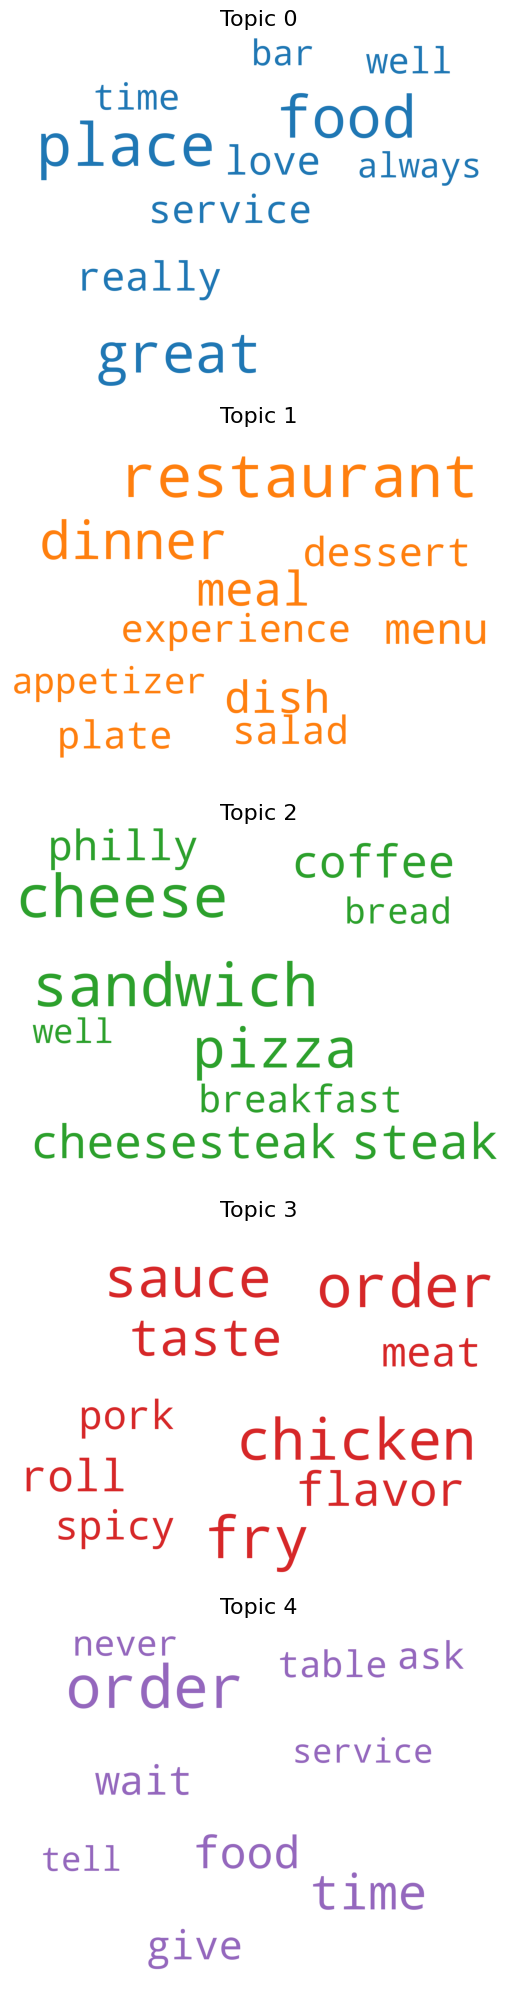

In [11]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 146.0 MB/s eta 0:00:00


In [14]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.160887 -0.062764       1        1  34.181300
4     -0.216541 -0.169263       2        1  26.715445
3      0.114196  0.088160       3        1  17.371469
1     -0.056774  0.272987       4        1  13.602201
2      0.320007 -0.129120       5        1   8.129586, topic_info=          Term           Freq          Total Category  logprob  loglift
85       great  114680.000000  114680.000000  Default  30.0000  30.0000
46       place  143919.000000  143919.000000  Default  29.0000  29.0000
41       order  125193.000000  125193.000000  Default  28.0000  28.0000
456   sandwich   34882.000000   34882.000000  Default  27.0000  27.0000
10      cheese   34175.000000   34175.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
521     pepper    4448.997514    8868.063366   Topic5  -5.2454   1.8199
1415    tomato    4249.414745    8298.405392   Topic5  -5.2913   1.8404
246      taste    5386.437281   41527.405438   Topic5  -5.0542   0.4672
195       cake    4357.588429   11234.519085   Topic5  -5.2662   1.5626
298      fresh    4583.644081   28994.676568   Topic5  -5.2156   0.6650

[317 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
193       1  0.999972     always
74        1  0.720365    amazing
74        3  0.000161    amazing
74        4  0.279444    amazing
718       3  0.049598  appetizer
...     ...       ...        ...
1350      1  0.101400       wing
1350      3  0.898548       wing
71        1  0.119273  wonderful
71        4  0.880677  wonderful
72        2  0.999821      write

[469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

In [15]:
# def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         # print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)

In [19]:
import pandas as pd

def format_topics_sentences(ldamodel, corpus, texts):
    rows = []

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        
        # Store each row as a tuple
        rows.append((int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]))

    # Create the DataFrame at once
    sent_topics_df = pd.DataFrame(rows, columns=['Topic', 'Perc_Contribution', 'Keywords', 'Text'])
    return sent_topics_df


In [20]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
print(df_topic_sents_keywords.head())

   Topic  Perc_Contribution  \
0      4             0.6343   
1      0             0.4317   
2      0             0.6522   
3      0             0.5745   
4      0             0.4007   

                                            Keywords  \
0  order, time, food, wait, give, ask, table, nev...   
1  place, food, great, really, love, service, tim...   
2  place, food, great, really, love, service, tim...   
3  place, food, great, really, love, service, tim...   
4  place, food, great, really, love, service, tim...   

                                                Text  
0  [almost, never, write, review, warn, people, b...  
1  [amazing, order, different, share, preferred, ...  
2  [find, place, walk, street, independence, grea...  
3  [way, dump, roll, second, time, guy, work, tru...  
4  [give, review, food, awesome, kind, grill, chi...  


In [22]:
print(df_topic_sents_keywords.columns)
print(df_topic_sents_keywords.shape)

Index(['Topic', 'Perc_Contribution', 'Keywords', 'Text'], dtype='object')
(250000, 4)


In [24]:
# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
# print(df_dominant_topic.shape)
# df_dominant_topic.head(10)

In [23]:
# Reset index adds a new index column, so we add 'Document_No'
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic', 'Perc_Contribution', 'Keywords', 'Text']

print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(250000, 5)


,Document_No,Topic,Perc_Contribution,Keywords,Text
0,0,4,0.6343,"order, time, food, wait, give, ask, table, nev...","[almost, never, write, review, warn, people, b..."
1,1,0,0.4317,"place, food, great, really, love, service, tim...","[amazing, order, different, share, preferred, ..."
2,2,0,0.6522,"place, food, great, really, love, service, tim...","[find, place, walk, street, independence, grea..."
3,3,0,0.5745,"place, food, great, really, love, service, tim...","[way, dump, roll, second, time, guy, work, tru..."
4,4,0,0.4007,"place, food, great, really, love, service, tim...","[give, review, food, awesome, kind, grill, chi..."
5,5,0,0.3592,"place, food, great, really, love, service, tim...","[breakfast, morning, cool, set, love, industri..."
6,6,0,0.6464,"place, food, great, really, love, service, tim...","[stumble, spot, cafe, intention, slide, close,..."
7,7,0,0.5140,"place, food, great, really, love, service, tim...","[live, philly, majority, life, honestly, hype,..."
8,8,3,0.4819,"order, fry, chicken, sauce, taste, flavor, rol...","[new, hot, spot, fishtown, love, raman, place,..."
9,9,0,0.5064,"place, food, great, really, love, service, tim...","[absurdly, disappointed, place, idea, stop, qu..."


In [26]:
# Append new columns onto reviews dataset
df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Topic', 'Keywords', 'Text_Chunks']]  # <- FIXED HERE
final_reviews = pd.concat([combined_reviews, extra_feature_columns], axis=1).reindex(combined_reviews.index)
final_reviews.head(10)

,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,month_year,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Topic,Keywords,Text_Chunks
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1.0,0.0,1.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015.0,1.0,00:01:03,2015-01,48.0,243.0,4.900000,12.0,"wow! yummy, different, delicious. favorite lam...",0.380051,0.733838,0.000,0.660,0.340,0.9588,4.0,"order, time, food, wait, give, ask, table, nev...","[almost, never, write, review, warn, people, b..."
1,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0.0,0.0,0.0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2013.0,6.0,11:21:25,2013-06,42.0,276.0,5.595238,17.0,tremendous service (big shout douglas) complem...,0.218750,0.579167,0.027,0.763,0.210,0.8360,0.0,"place, food, great, really, love, service, tim...","[amazing, order, different, share, preferred, ..."
2,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,0.0,0.0,0.0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,2014.0,11.0,15:30:27,2014-11,81.0,419.0,4.185185,32.0,absolute favorite cafe city. black white latte...,0.391171,0.609921,0.025,0.738,0.237,0.9679,0.0,"place, food, great, really, love, service, tim...","[find, place, walk, street, independence, grea..."
3,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5.0,0.0,0.0,0.0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,2018.0,8.0,21:39:38,2018-08,73.0,393.0,4.397260,25.0,"boyfriend tried deli first time today. turkey,...",0.152778,0.492593,0.000,0.843,0.157,0.9168,0.0,"place, food, great, really, love, service, tim...","[way, dump, roll, second, time, guy, work, tru..."
4,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4.0,0.0,0.0,0.0,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,2015.0,3.0,03:37:54,2015-03,422.0,2343.0,4.547393,178.0,"reason give restaurant 5 star rating, one sing...",0.098299,0.476332,0.053,0.857,0.089,0.9305,0.0,"place, food, great, really, love, service, tim...","[give, review, food, awesome, kind, grill, chi..."
5,ZGjgfSvjQK886kiTzLwfLQ,EtKSTHV5Qx_Q7Aur9o4kQQ,5.0,3.0,1.0,1.0,"On a scale of one to things that are awesome, ...",2009-10-14 01:15:04,2009.0,10.0,01:15:04,2009-10,177.0,934.0,4.189944,77.0,"scale one thing awesome, place bomb. drawn pro...",0.486364,0.581818,0.033,0.880,0.086,0.7376,0.0,"place, food, great, really, love, service, tim...","[breakfast, morning, cool, set, love, industri..."
6,IKbjLnfBQtEyVzEu8CuOLg,VJEzpfLs_Jnzgqh5A_FVTg,4.0,0.0,0.0,0.0,It was my fiance's birthday and he decided he ...,2014-04-01 13:05:18,2014.0,4.0,13:05:18,2014-04,214.0,1135.0,4.308411,91.0,"fiance's birthday decided wanted good, laid ba...",0.244048,0.488095,0.017,0.821,0.162,0.9894,0.0,"place, food, great, really, love, service, tim...","[stumble, spot, cafe, intention, slide, close,..."
7,mNITUu6B2wUKBOa4NmUHJg,NQSnr4RPUScss607oxOaqw,5.0,0.0,0.0,0.0,My brother came to visit and we wanted to pick...,2016-05-19 06:10:14,2016.0,5.0,06:10:14,2016-05,63.0,330.0,4.253968,27.0,brother came visit wanted pick six pack good b...,0.626667,0.723333,0.000,0.756,0.244,0.9545,0.0,"place, food, great, really, love, service, tim...","[live, philly, majority, life, honestly, hype,..."
8,aWlojpSpzEICTza3RgGJgg,SIoCIxjn4jLt2O-4DajWJw,4.0,0.0,0.0,0.0,My go-to spot on a Saturday night! I was real ...,2015-11-18 17:47:29,2015.0,11.0,17:47:29,2015-11,72.0,396.0,4.438356,26.0,go-to spot saturday night! real bummed lucy cl...,0.011667,0.588333,0.057,0.720,0.224,0.9363,3.0,"order, fry, chicken, sauce, taste, flavor, rol...","[new, hot, spot, fishtown, love, raman, place,..."
9,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,5.0,1.0,1.0,1.0,I've only had the cannolis here but they are a...,2018-03-23 14:35:33,2018.0,3.0,14:35:33,2018-03,44.0,256.0,4.840909,21.0,cannolis awesome! freshly filled ordered filli...,0.541667,0.758333,0.095,0.616,0.288,0

In [28]:
# # Save final_reviews into csv file

# final_reviews.to_csv("Data/Part_3/final_reviews.csv")

In [29]:
import os

# Create directory if it doesn't exist
os.makedirs('Data/Part_3', exist_ok=True)

# Now save the file
final_reviews.to_csv("Data/Part_3/final_reviews.csv", index=False)
print("File saved successfully!")

File saved successfully!
